Fitting 5 folds for each of 72 candidates, totalling 360 fits
Accuracy: 0.7244258872651357

Classification Report:
               precision    recall  f1-score   support

           A       0.43      0.14      0.21        21
           B       0.57      0.50      0.53        54
           C       0.52      0.67      0.58        78
           D       0.53      0.46      0.49        83
           F       0.90      0.93      0.92       243

    accuracy                           0.72       479
   macro avg       0.59      0.54      0.55       479
weighted avg       0.71      0.72      0.71       479



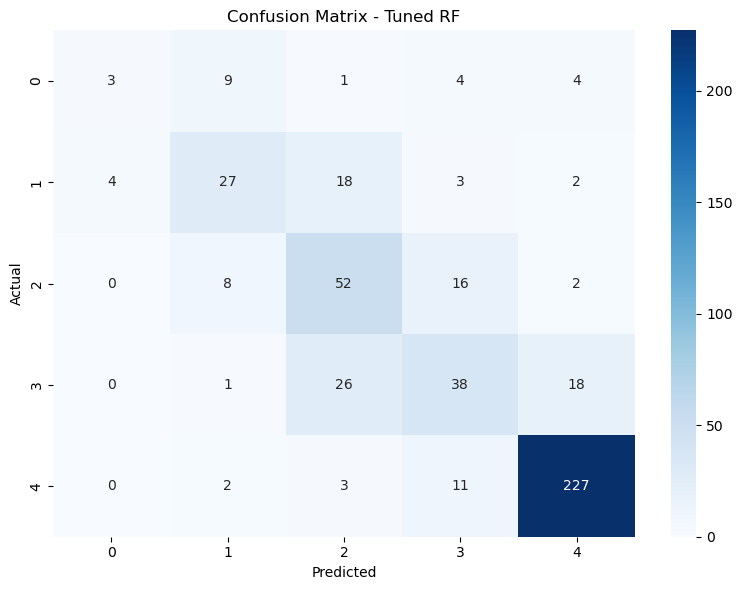

First 20 Predictions:


,Actual,Predicted,Match
0,4.000000,4.000000,True
1,4.000000,4.000000,True
2,4.000000,4.000000,True
3,4.000000,4.000000,True
4,2.000000,1.000000,False
5,3.000000,3.000000,True
6,2.000000,2.000000,True
7,4.000000,4.000000,True
8,4.000000,4.000000,True
9,3.000000,4.000000,False


Predicted Grade: C ,for given student input


C:\Users\oosun\AppData\Local\Temp\ipykernel_2936\2600039980.py:105: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_input = df_input.apply(pd.to_numeric, errors='ignore')  # Cast numerics properly


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

#Step 1: Import CSVs
df_train = pd.read_csv('../data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["StudentID", "GradeClass", "GPA"])
y_train = df_train['GradeClass']

X_test = df_test.drop(columns=["StudentID", "GradeClass", "GPA"])
y_test = df_test['GradeClass']

# Step 3: Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 14, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=47),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Step 4: Picking best model from tuning
best_rf = grid_search.best_estimator_

#Step 5: Save the model as pkl file in artifacts
with open("../artifacts/randomforest_model.pkl", "wb") as file:
    pickle.dump(best_rf, file)

#Step 6: Predictions
predictions = best_rf.predict(X_test)

# Step 7: Evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions, target_names=["A", "B", "C", "D", "F"]))

#Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Tuned RF')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Step 8: Show and save the prediction table
try:
    from IPython.display import display

    # Prepare DataFrame for display
    comparison_df = pd.DataFrame({"Actual": y_test.values,"Predicted": predictions})
    comparison_df["Match"] = comparison_df["Actual"] == comparison_df["Predicted"]

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comparison_df.head(20).style.apply(highlight_false_text, axis=1))

except Exception as e:
    print("\n First 20 Predictions:")
    print(comparison_df.head(20).to_string(index=False))

#Step 9: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual_GradeClass"] = y_test.values
comparison_df["Predicted_GradeClass"] = predictions
comparison_df.to_csv("../data/randomforest_prediction.csv", index=False)

#Prediction function for the given input test
def predict_student_grade(input_string):
    columns = ["Age", "Gender", "Ethnicity", "ParentalEducation", "StudyTimeWeekly", "Absences", "Tutoring", "ParentalSupport", "Extracurricular","Sports", "Music", "Volunteering"]

    # Convert input string into a list
    input_data = input_string.split(",")

    # Automatically remove the first value (StudentID) and last two values (GPA & GradeClass)
    input_data = input_data[1:-2] # Removes 1 from start and last 2 items

    # Create DataFrame from input
    df_input = pd.DataFrame([input_data], columns=columns)
    df_input = df_input.apply(pd.to_numeric, errors='ignore')  # Cast numerics properly

    # Predict using the loaded model
    prediction = best_rf.predict(df_input)
    
    #Mapping numeric class baack to the letter grade
    grade_map = {0: "A", 1: "B", 2: "C", 3: "D", 4: "F"}

    predicted_grade = grade_map[prediction[0]]

    return predicted_grade

#Step 10: Example testing input from the csv file
student_input = "1001,17,1,0,2,19.833722807854713,7,1,2,0,0,1,0,2.929195591667681,2.0"

#Print predicted grade
print(f"Predicted Grade: {predict_student_grade(student_input)} ,for given student input")